### Code used for applying the proposed SOM-NBL clustering framework:

#### This code computes the NBL for a set of groundwater compounds available, and later can be used to compute the clustering of the selected compounds. 


#### 1. First, this code reads several time-series of groudwater compounds and compute the  NBL range:

The NBL illustrates what thresholds are likely signs of anthropogenic effect by indicating how high or low a parameter's value would be expected under natural conditions (Moreau and Daughney, 2021). The NBL is computed as the average main descriptors of the wells with NO3 concentrations < 10 mg/L. The maximum NBL is defined as the 90th percentile concentration of the the average final values. This methdology assumes that wells with NO3 concentrations below 10 mg/L can be considered as in the aquifer natural conditions as shown in Lions et al. (2021). 


Requirements: The dataset needed is a simple table with Code, Lat and Lon of your wells to be used in a .xlsx file, and several .xlsx files for each available compound. It is important that each file represents one different compound time-series, with the columns representing each measurement point (well), and that the name of each follows the example: Nitrates = "NO3.xlsx". 


#### 2. Secondly, this script uses the median concentration (of a selected range), and selected compounds and their respective NBLs to proceed with the som clustering.


References: 

do Nascimento, TVM; Condesso de Melo, MT; de Oliveira, RP. (2023) Framework for clustering groundwater quality using 
Self-Organizing Maps to improve aquifer monitoring and management: a case study of the Gabros de Beja aquifer system, PortugaL.EGU23
https://doi.org/10.5194/egusphere-egu23-564
    
    
Moreau, M., & Daughney, C. 2021). Defining natural baselines for rates of change in New Zealand’s 
groundwater quality: Dealing with incomplete or disparate datasets, accounting for impacted sites, and 
merging into state of the-environment reporting. Science of The Total Environment, 755, 1–17. 
https://doi.org/10.1016/J.SCITOTENV.2020.143292

Lions, J., Devau, N., Elster, D., Voutchkova, D. D., Hansen, B., Schullehner, J., Petrović Pantić, T., Samolov, 
K. A., Camps, V., Arnó, G., Herms, I., Rman, N., Cerar, S., Grima, J., Giménez-Forcada, E., Luque Espinar, J. A., Malcuit, E., & Gourcy, L. (2021). A Broad-Scale Method for Estimating Natural 
Background Levels of Dissolved Components in Groundwater Based on Lithology and Anthropogenic 
Pressure. Water, 13(1531). https://doi.org/10.3390/W13111531

Script by: Thiago Victor Medeiros do Nascimento

In [39]:
import glob, os
import pandas as pd
import numpy as np

from minisom import MiniSom

import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings
warnings.simplefilter(action='ignore', category=Warning)


%config Completer.use_jedi = False # This improve the auto-fill function

First we should set our directory:

In [2]:
path = r"C:\Users\nascimth\Documents\Thiago\Projects\gwquality-analysis\SOM_clustering"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Projects\\gwquality-analysis\\SOM_clustering'

At this part the wells information, such as code, latitute and longitute coodidinates, are retrieved from a XLSX file: 

In [3]:
wells_infos=pd.read_excel('codes.xlsx')
wells_infos.set_index('Code', inplace=True)
wells_infos.head()

,xcoord,ycoord
Code,,
509/17,-8.067555,38.080698
532/136,-7.604608,37.921637
521/44,-7.925157,38.014586
521/445,-7.915270,38.019451
520/65,-8.068878,38.040563


In [4]:
import nbl_som_clustering as nbl_som_clustering

Here we can read the filenames of the available compounds:

In [5]:
path = 'dataset'
filenames = glob.glob(path + "/*.xlsx")
filenames

['dataset\\Al.xlsx',
 'dataset\\Ca.xlsx',
 'dataset\\Cl.xlsx',
 'dataset\\EC.xlsx',
 'dataset\\EClab.xlsx',
 'dataset\\Fe2.xlsx',
 'dataset\\HCO3.xlsx',
 'dataset\\K.xlsx',
 'dataset\\Mg.xlsx',
 'dataset\\Mn2.xlsx',
 'dataset\\Na.xlsx',
 'dataset\\NO2.xlsx',
 'dataset\\NO3.xlsx',
 'dataset\\P.xlsx',
 'dataset\\pH.xlsx',
 'dataset\\pHlab.xlsx',
 'dataset\\PO.xlsx',
 'dataset\\SO4.xlsx',
 'dataset\\T.xlsx']

At this part we can check the compound names based on their respective files:

In [6]:
compounds = nbl_som_clustering.names_compounds(filenames)
compounds

['Al',
 'Ca',
 'Cl',
 'EC',
 'EClab',
 'Fe2',
 'HCO3',
 'K',
 'Mg',
 'Mn2',
 'Na',
 'NO2',
 'NO3',
 'P',
 'pH',
 'pHlab',
 'PO',
 'SO4',
 'T']

Here we can compute the full NBL table (with the descriptors), and the maximum NBL (i.e., the P90):

In [7]:
tablebaseline, max_nbl = nbl_som_clustering.compute_NBL(filenames, wells_infos)

Plot the maximum NBL:

In [8]:
max_nbl

Al         0.29400
Ca        40.73000
Cl        29.77000
EC             NaN
EClab          NaN
Fe2            NaN
HCO3     127.50000
K          1.79780
Mg        17.68000
Mn2            NaN
Na        14.60000
NO2        0.10038
NO3        6.61800
P              NaN
pH         8.10000
pHlab          NaN
PO             NaN
SO4       33.07000
T         21.00000
Name: 90%, dtype: float64

2. SOM clustering part:

First we select the representative compounds components (e.g., NO3, SO4 and Cl) and compute its median concentration for a specific time-frame (e.g., 2015-2022):

In [9]:
compounds_used = ['NO3', 'SO4', 'Cl']

dataforcluster = nbl_som_clustering.compounds_forclustering(filenames, compounds_used, 
                                                            start_range = '2016',
                                                            end_range = '2021')

In [11]:
# Finally, we can drop the lines with NaN. 
dataforcluster.dropna(inplace = True)
dataforcluster

,NO3,SO4,Cl
509/17,26.000,47.250,47.000
509/198,52.250,38.250,34.250
509/220,11.900,78.000,105.000
509/299,49.950,40.325,38.700
509/300,35.000,98.400,102.000
509/301,17.300,41.100,20.400
509/302,51.725,36.925,31.750
520/14,43.000,70.250,79.250
520/15,67.000,52.250,56.250
520/64,121.000,109.800,60.000


For this part we can use the module so-called Minisom to run the clustering algorithm.

In [22]:
#%% Data balancing:
# Here we divide our concentration by their maximum NBL previous computed:
databalanced = dataforcluster / max_nbl.loc[dataforcluster.columns]

databalanced

,NO3,SO4,Cl
509/17,3.928679,1.428787,1.578771
509/198,7.895134,1.156637,1.150487
509/220,1.798126,2.358633,3.527041
509/299,7.547597,1.219383,1.299966
509/300,5.288607,2.975507,3.426268
509/301,2.614083,1.242818,0.685254
509/302,7.815805,1.116571,1.066510
520/14,6.497431,2.124282,2.662076
520/15,10.123905,1.579982,1.889486
520/64,18.283469,3.320230,2.015452


In [26]:
data = databalanced
# Som clustering:
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# Initialization and training
som_shape = (6, 1) # Architecture of the network
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=100)

som.train_batch(data, 2000, verbose=True)

# Each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# with np.ravel_multi_index we convert the bidimensional coordinates to a monodimensional index:
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

cluster_index

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.7311442225999978


array([0, 1, 5, 1, 5, 0, 1, 5, 1, 3, 1, 1, 1, 4, 5, 1, 3, 2, 0, 4, 2, 1,
       0, 0, 3, 1, 4, 2, 1, 0, 5, 3, 2, 3, 3, 1, 1, 5, 5, 2, 0, 1, 0, 1,
       1], dtype=int64)

In [32]:
clusters = databalanced.copy()
clusters["cluster"] = cluster_index

clusters["Lat"] = wells_infos["ycoord"]
clusters["Lon"] = wells_infos["xcoord"]

clusters

,NO3,SO4,Cl,cluster,Lat,Lon
509/17,3.928679,1.428787,1.578771,0,38.080698,-8.067555
509/198,7.895134,1.156637,1.150487,1,38.056568,-8.104721
509/220,1.798126,2.358633,3.527041,5,38.088281,-8.110978
509/299,7.547597,1.219383,1.299966,1,38.061400,-7.966103
509/300,5.288607,2.975507,3.426268,5,38.088344,-8.110271
509/301,2.614083,1.242818,0.685254,0,38.058623,-8.107489
509/302,7.815805,1.116571,1.066510,1,38.080847,-8.015547
520/14,6.497431,2.124282,2.662076,5,38.030490,-7.954498
520/15,10.123905,1.579982,1.889486,1,38.032783,-7.983879
520/64,18.283469,3.320230,2.015452,3,38.033341,-7.983047


<AxesSubplot:>

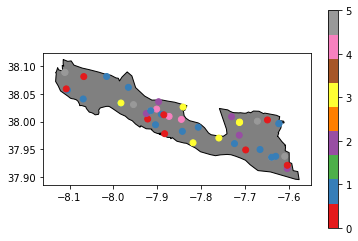

In [41]:
#%% Plot the data:
#wells_gauges = wells_gauges.join(wtypes)
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(clusters["Lon"], clusters["Lat"])]
geodata=gpd.GeoDataFrame(clusters,crs=crs, geometry=geometry)
gabros_shapefile = gpd.read_file(r'gabros.shp')


# Plot:
fig, ax = plt.subplots()
gabros_shapefile.plot(ax=ax, facecolor='gray', edgecolor='k',alpha=1,linewidth=1)
geodata.plot(column='cluster', ax=ax, legend=True, cmap='Set1')

In [45]:
# Build a table with the statistical descriptors per cluster:
table = pd.DataFrame()
for cluster in(range(6)):
    
    rownameno3 = "NO3-CL" + str(cluster)
    rownameso4 = "SO4-CL" + str(cluster) 
    rownamecl = "Cl-CL" + str(cluster)
    
    indexes = clusters["cluster"] == cluster
    table[rownameno3] = dataforcluster.loc[indexes,"NO3"].describe(percentiles=[.10, .25, .5, .75, .90, .95])
    table[rownameso4] = dataforcluster.loc[indexes,"SO4"].describe(percentiles=[.10, .25, .5, .75, .90, .95])
    table[rownamecl] = dataforcluster.loc[indexes,"Cl"].describe(percentiles=[.10, .25, .5, .75, .90, .95])
    

In [48]:
table.T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
NO3-CL0,8.0,24.237500,12.096037,4.100,12.4300,16.97500,25.5000,28.75000,38.6500,40.57500,42.500
SO4-CL0,8.0,30.156250,9.452860,18.425,22.1350,24.68125,28.3750,32.02500,42.9450,45.09750,47.250
Cl-CL0,8.0,33.103125,14.128634,19.975,20.2725,23.10000,28.7250,39.12500,50.7500,55.12500,59.500
NO3-CL1,16.0,55.696875,8.745169,38.250,50.1875,50.82500,52.6250,61.51875,68.7500,70.84375,71.875
SO4-CL1,16.0,45.104687,9.163784,32.750,37.4625,38.28750,41.7000,50.56250,56.3625,60.53125,67.000
Cl-CL1,16.0,45.614063,18.062846,16.500,23.9750,30.93750,46.4125,62.25625,65.5000,68.12500,72.250
NO3-CL2,5.0,100.400000,22.247612,78.500,80.3000,83.00000,101.2500,104.50000,122.6500,128.70000,134.750
SO4-CL2,5.0,48.995000,7.984955,40.750,42.0500,44.00000,45.7250,54.50000,57.8000,58.90000,60.000
Cl-CL2,5.0,49.325000,18.213491,32.750,35.2500,39.00000,40.0000,57.37500,69.4500,73.47500,77.500
NO3-CL3,6.0,94.337500,15.450241,77.450,79.4125,84.20625,93.3500,98.12500,110.2500,115.62500,121.000
